# Image segmentation with Graph Neural Network (GNN)

## Installation
### Install requirements

In [1]:
#! pip install networkx
#! pip install torch
#! pip install scipy
#! pip install ipycanvas

### Import

In [2]:
import pyopenpose as op
import cv2
import time
import numpy as np
import os
import json
import sys

from matplotlib import pyplot as plt
from tqdm import tqdm

try:
    from myOpenpose import *
    from myHandGraph import *
    
except:
    sys.path.append('/home/nmiguens/Python')
    from myOpenpose import *
    from myHandGraph import *

## Load Data

From Openpose output, use keypoints to build a graph.

### Prepare datasets requirements

In [3]:
path = "/home/nmiguens/Datasets/ph2014-dev-set-handshape-annotations"
annotations = open(os.path.join(path,"3359-ph2014-MS-handshape-annotations.txt"), "r").read()
annotations_lignes = annotations.split("\n")

print(annotations_lignes[0].split(" "))

with open(os.path.join(path,'RWTH_words_count.txt')) as json_file:
    words_count = json.load(json_file)
    
words_count["1"]

['images/final_phoenix_noPause_noCompound_lefthandtag_noClean/01February_2011_Tuesday_heute_default-8/1/*.png_fn000030-0.png', 'write']


528

### Extract data

In [4]:
# Seuil du nombre d'échantillon par classe
threshold = 80

# Chemin des fichiers JSON
JSONpath = "/home/nmiguens/JSON/RWTH-PHOENIX_hand_OptimizedParam"

start = time.time()

X = []
y = []
images = []
convertionTab = []
countTab = dict()

for imageId in tqdm(range(len(annotations_lignes))):

    imagePath, imageClass = annotations_lignes[imageId].split(" ")
    
    if imageClass in countTab :
        countTab[imageClass] += 1
    else :
        countTab[imageClass] = 1
    
    if words_count[imageClass] >= threshold and countTab[imageClass] <= threshold :
        
        y.append(imageClass)
    
        imagePath = os.path.join(path, imagePath)
        images.append(imagePath)
        
        jsonFile = os.path.join(JSONpath, "{}_keypoints.json".format(imageId))
        x = json_2_numpy(jsonFile, body = False, hand = True, face = False)
        X.append(x)
        
        convertionTab.append(imageId)
end = time.time()
print("OpenPose extraction successfully finished. Total time: " + str(end - start) + " seconds")

X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

100%|██████████| 3359/3359 [00:04<00:00, 790.24it/s]

OpenPose extraction successfully finished. Total time: 4.253300189971924 seconds
(880, 126)
(880,)


### Transform data

In [5]:
graphs = getNodes(X)
graphs.shape

(880, 21, 3)

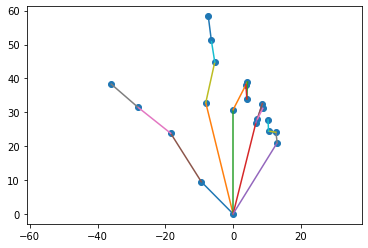

Canvas(height=200, width=200)

In [6]:
index = 400

params = set_params(face = False, body = 0, hand = True, hand_detector = 2, hand_opti = False)
imagePath = images[index]
#opImage_display(imagePath, params)

displayGraph(graphs[index], coef = 1)

#### Define datasets class

Pytorch provides an abstract class representig a dataset, torch.utils.data.Dataset. We need to override two methods:

- __ len __ so that len(dataset) returns the size of the dataset.
- __ getitem __ to support the indexing such that dataset[i] can be used to get i-th sample

## Define Model

In [7]:
graphSet , loader = splitXy(X, y) 
trainset, vaildset, testset = graphSet
train_loader, valid_loader, test_loader = loader

## Training setup

100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


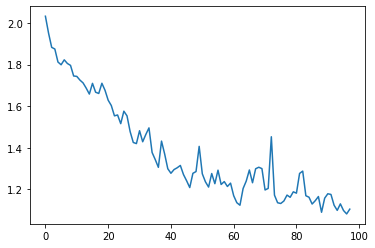

In [9]:
import torch.optim as optim
import torch.nn.functional as F


model = Net(3, 64, 11)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()

epoch_losses = []
for epoch in tqdm(range(100)):
    epoch_loss = 0
    for iter, (bn, be, gs, label) in enumerate(train_loader):
        prediction = model(bn, be, gs)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
        
plt.plot(epoch_losses[2:])
plt.show()

## Evaluation

In [13]:
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]


model.eval()
acc = 0
with torch.no_grad():
  for iter, (bn, be, gs, label) in enumerate(test_loader):
    prediction = model(bn, be, gs)
    acc += accuracy(prediction, label) * label.shape[0]
acc = acc/len(testset)

print('Test accuracy {:.4f}'.format(acc))

Test accuracy 46.2121


## Others Models